# Financial Derivatives Pricing Using Simulation: Approaches to Option Pricing

In [ ]:
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
!pip install yfinance
import yfinance as yf
import seaborn as sns
from IPython.display import Image
from scipy.stats import norm

## Introducing Options

**Options** are a type financial derivative that gives the buyer the right, but not the obligation to purchase or sell the underlying stock at the predetermine price. An option have several attribute:
1. **Type**: Type of option, Call or Put
2. **Strike Price**: Price the owner can exercise at.
3. **Time to Maturity**: The time until in which the option contract is valid.
4. **Price**: The contract comes with a price. We want to model the fair value of the price in this project.


### Derivative Pricing Mechanism

In traditional finance due to no arbitrage theory, the fair value of a financial asset is the present value of its expected payoff. The present value is calculated by taking the payoff and discounting it back to a present value using current spot risk-free rate. In simple terms, a purchaser of a asset today should not be awarded additional value for simply purchasing the asset.

For a European options specifically, the value of the option will be its payoff at maturity discounted back to present value.

- *For a call option* the owner will exercise the option if the underlying price is higher than the strike price. Other wise he will not exercise the option, leaving a payoff of a negative net payoff of the price he paid for that option.
- *For a put option*, the owner will exercise the option if the underlying price is lower than the strike price. Other wise he will not exercise the option, leaving a payoff of 0 and a negative net payoff of the price he paid for that option.

The two most common option existing on the market are knows as a European option and an American Option.
- A **European option** is a standard option that is only exercise at the maturity date.
- A **American option** is an option that can be exercise at any time before the maturity date.

Below is an representation of their payoff. We will be looking at longing the asset in this projrect.

![](https://analystprep.com/blog/wp-content/uploads/2020/08/cfa-frm-options-payoffs-2.png)

## Monte Carlo Simulation Approach: A Simple Start

We mentioned how the price of the european option is dependant on its state of payoff at the maturity. The challenge now lies how we are going to model something in the future. This is where we can utilize simulations in python along with stochastic processes to help us model and simulate the options prices by first simulating the underlying stock prices in the future.

The Monte Carlo Simulation basically first helps us simulate the underlying stock prices upon till the date of maturity. We can sue the sample paths generated to than value the option individually and lastly averaging the result.



### 1. Modeling Stock Prices:

The method utilized to generate future stock prices in a Monte Carlo simulation for option pricing is typically done using geometric Brownian motion. The formula I used is shown below:

$$
S_t = S_0*e^{(u - \frac{\sigma}{2})d_t+\sigma dW(t)}
$$


$S_t$ = Stock Prices at time t , $S_o$ = stock prices at time 0

$u$ = Average Return. (Assumption is in Monte Carlo is that the return is equal to the return of the risk free rate minus dividend yield. We ignore the dividend yield in this project)

$\sigma$ = Annualized Standard Deviation of stock price, Volatility

$W(t)$ = Wiener Process ~ $N(0,\sqrt{t})$

We will try to use these input below to first model the stock prices only. Moreover, we first just want our model to work hence we are simplifying many of the inputs.

**Code Adaptations and Source https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9**

In [ ]:
def simulatepath (S,T,r,sigma,steps,N):
    #Inputs:
    #S = Current stock Price
    #T = Time to maturity / period in which we want to model. In unit of years
    #r = risk free interest rate (assume no dividend yield)
    #steps = time increments
    # sigma = volatility of stock

    dt = T/ steps  #time increment
    drift = (r - 0.5 * sigma ** 2) #Drift Term
    vol = sigma * math.sqrt(dt) #volatility term
    rand = np.random.standard_normal((steps + 1, N)) #array of random normal vairable in the size of (steps+1,N)
    St = S * np.exp(np.cumsum(drift * dt + vol*rand, axis=0)) #Using cumsum to store the random values the values in St

    return St



Now that we have the code in place. We can try to mode some stock prices. I choose to model Tesla (TSLA) stock prices from 1 year from now. Ideally, we can use live stock data prices from many packages available in python. I will first implement the input manually for simplicity.

In [ ]:
S = 937 #stock price S_0
T = 1 # time to maturity
r = 0.005 # (random number) risk free risk in annual
sigma = 0.005 # (random number) annual volatility
steps = 100 # time steps
N = 3 #Number of Path

#simulate tsla stock price path
tsla_paths = simulatepath(S,T,r,sigma,steps,N)

What we see here is the path simulated in the formula of a matrix where number of columns are the number of paths, and the number of rows are the nunber of time increments. Each individual row represent one path. Lets put that in a picture to visualize.

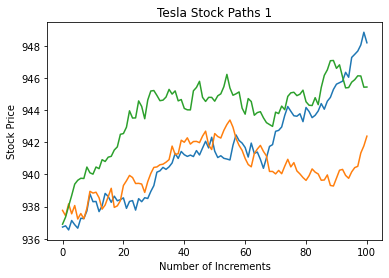

In [ ]:
plt.plot(tsla_paths);
plt.xlabel("Number of Increments")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Paths 1")
plt.show()

Obvisouly, we need to increase the number of time increments as well as the number of paths for bettter accruacy.

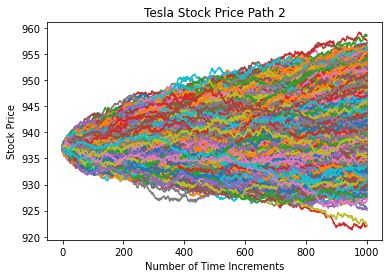

In [ ]:
steps = 1000
N = 10000
tsla_paths2 = simulatepath(S,T,r,sigma,steps,N)
plt.plot(tsla_paths2);

plt.xlabel("Number of Time Increments")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price Path 2")
plt.show()

We can now find the simulated stock price of TSLA one year from today by averaging the all the path's outcomes.

In [ ]:
Tsla_simulated_price = np.mean(tsla_paths2[-1]) #The end of the array is the price at time T
print('The Simulated TSLA is',Tsla_simulated_price)

The Simulated TSLA is 941.6321297810899


Due to central limit theorem, as we increase the number of trials, the mean should converge to a target level. We can graph the price of our  modeld 1-year TSLA stock price from the Monte Carlo simulation against the paths taken to see that relationship:

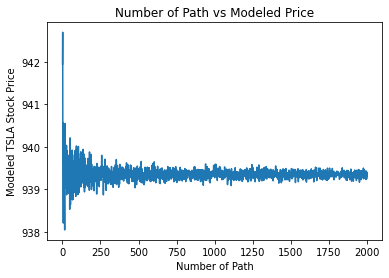

In [ ]:
S = 937
T = 1
r = 0.005
sigma = 0.005
steps = 1000

x= []
y= []
for i in range(1,2000):
    outcome = np.mean(simulatepath(S,T,r,sigma,steps,i))
    x.append(i)
    y.append(outcome)


plt.plot(x,y)
plt.xlabel("Number of Path")
plt.ylabel("Modeled TSLA Stock Price")
plt.title("Number of Path vs Modeled Price")
plt.show()


### 2. Modeling option prices

Now that we can model the stock prices, we can derive the option payoffs using this method. The method to achieve that is for each individual path, we take the stock price at time T and ask ourselves 'If I were to someone who holds the option, would I choose to exercise the option for a profit?'.

- For a call option, the answer is 'YES' if our modeled stock price at time T is larger than the strike price of the option. Than the payoff we get at time T is stock price at time T minus the strike price. Otherwise, than the owner of the option does not exercise the option, leaving a payoff of 0.

- For a put option, the answer is 'YES' if our modeled stock price at time T is smaller than the strike price of the option. Than the payoff we get at time T is the strike price minus our modeled price at time T. Otherwise, than the owner of the option does not excerise the option, leaivng a payoff of 0.

Lets First Start with a Call option. Lets assume we are trying to find the price of a TSLA call with a maturity of 1 year and a strike of 950:

In [ ]:
#Simulate
k = 900 #strike
S = 937
T = 1
r = 0.005
sigma = 0.005
steps = 1000
N = 1000
tsla_paths3 = simulatepath(S,T,r,sigma,steps,N)

# pay off of the call option: max(St-K, 0)

payoffs = np.maximum(tsla_paths3[-1]-k, 0) #choose the maxinum between (St-k, 0)
call_price = np.mean(payoffs)*np.exp(-r*T)# Discount back to present value using continuous compounding

print(call_price)

41.43989482472563


Nice! We can now sucessfully model and simulate the price of a european option using monte carlo simulation using the ismplified assumptions. Lets now modulize the code:

In [ ]:
# Modulize Call
def mc_call(S,T,r,sigma,steps,N,K):
    x = simulatepath(S,T,r,sigma,steps,N)
    payoffs = np.maximum(x[-1]-k, 0)
    call_price = np.mean(payoffs)*np.exp(-r*T)

    return call_price

# Modulize put
def mc_put(S,T,r,sigma,steps,N,K):
    x = simulatepath(S,T,r,sigma,steps,N)
    payoffs = np.maximum(k-x[-1], 0)
    put_price = np.mean(payoffs)*np.exp(-r*T)

    return put_price

## Automating the Process Using Live Data and Tailoring Inputs

Now that we have a rough model ready, in order for it to be meangful, now it is the time to tailor our inputs correctly.
To make these modules more useful, it is better if we can utilize some sort of live databases for real time data. There are a few inputs in my model that I think can be utilizing live stock data, but there are also inputs within the data in which we can tailor to increase its accuracy. Lets start with the obvious one which is the current stock price:

### 1. Live Stock Prices

The packaged I used is **Yahoo Finance** in which I can get real-time financial data. First, lets say if I want the **TSLA** stock price from the beginning of **December 01, 2021** to today (**December 18, 2021**). I can indeed manually input the date today:

In [ ]:
tsla_df = yf.download('TSLA',start = '2021-12-01', end = '2021-12-20')
tsla_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-01,1160.699951,1172.839966,1090.760010,1095.000000,1095.000000,22816800
2021-12-02,1099.060059,1113.000000,1056.650024,1084.599976,1084.599976,24371600
2021-12-03,1084.790039,1090.579956,1000.210022,1014.969971,1014.969971,30696300
2021-12-06,1001.510010,1021.640015,950.500000,1009.010010,1009.010010,27221000
2021-12-07,1044.199951,1057.670044,1026.810059,1051.750000,1051.750000,18694900


I can automate this process to always get the stock price today utilizing the datetime function and some pandas manipulations.

In [ ]:
from datetime import date
today= date.today() #find date today
date = today.strftime("%Y-%m-%d") #format the date format to the ones used in yfinance

tsla_df = yf.download('TSLA',start = '2021-12-1', end = date) #pd dataframe of stock price
tsla_today = tsla_df['Adj Close'][tsla_df.index[-1]] #last row of the adj close column

print('The price of TSLA at',date, 'is $',tsla_today)

[*********************100%***********************]  1 of 1 completed
The price of TSLA at 2021-12-21 is $ 899.9400024414062




Now modulize the function for simplicity using a function with ticker and date today as an input:

In [ ]:
def get_price(ticker, date):
    ticker_df = yf.download(ticker,start = '2021-12-1', end = date)
    ticker_today = ticker_df['Adj Close'][ticker_df.index[-1]]

    return ticker_today

## 2. Live interest rate

The interst rate we use as parameter in our model is the risk free interst rate. I personally will use the bond yield from a 10 year US treasury bill. Lets modulize a function that can help us get live time risk free rate.

In [ ]:
def get_rate(date):
    ratedata_df = yf.download('^TNX',start = '2021-12-1', end = date)  #^TNX is the ticker for 10year Treasury Yield
    risk_free_rate = ratedata_df['Adj Close'][ratedata_df.index[-1]]/100 #Take Last row of adj column. Rate is expressed in percetage hence divide by 100

    return risk_free_rate

print( 'The Risk Free rate today is ', get_rate(date))

[*********************100%***********************]  1 of 1 completed
The Risk Free rate today is  0.014190000295639039


## 3. Volatilty

Volatility is a tricky metric to tailor well. To start with, a drawback of the Monte Carlo Simulation itself is that it consider volatility of the stock to be constant, which is not practical in the real world as we know the degree of fluctuations of stock differs by time. There are two popular approach for us to model volatility of a stock price

1. Historical Volatility: Historical Volatility is using the historical data of the stock to estimate a average volatility to use as input in our model. This is a common approach, but not exactly accurate if we want our model to correspond to the current market dynamic
2. Implied Volatility: Implied volatility is the volatility that is currently implied within the existing options. This implied volatility is an accurate representation of how the market views the future dynamic within a particular stock. The method to achieve that is to input the current option price within the famous Black-Schole Formula, in which will be introduced later.

In this project we will try to use both methods to compare our result.

### - Historical Volatility

Lets try to first find the historical volatility of the stock using the data from 5 years ago to today. First, we need to compute the daily percentage return of the stock prices. We can graph that with a visualization.

[*********************100%***********************]  1 of 1 completed


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'TSLA Daily Returns Distribution'),
 Text(0.5, 0, 'Returns')]

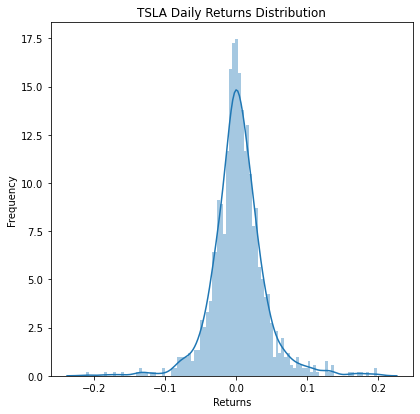

In [ ]:
# Get Real Time Data Base
tsla_df = yf.download('TSLA',start = '2016-12-19', end = date)
tsla_df['Percentage_return']= tsla_df['Adj Close'].pct_change()

#Graphing daily returns
fig, ax = plt.subplots(figsize=(6.5,6.5))
return_figure = sns.distplot(tsla_df['Percentage_return'],norm_hist=True,bins=100)
return_figure.set(ylabel='Frequency', title='TSLA Daily Returns Distribution',xlabel='Returns')


We see that the distribution is indeed roughly normal. Now we find the historical annualized volatility by first calculating the standard deviation of the daily returns, and than multiplying the number by the square root of the number of trading days in a year, 252.

In [ ]:
daily_std = np.std(tsla_df['Percentage_return'])
vol = daily_std*np.sqrt(252) #Annulize daily volatility. Using 252, standard convention of number of traidng days

print('The estimated annualized volatility of TSLA is equal to', vol)

The estimated annualized volatility of TSLA is equal to 0.6017656165797797


Modulize Code Again:

In [ ]:
def get_HV(ticker,date):
    df = yf.download(ticker,start = '2016-12-19', end = date)
    df['Percentage_return']= tsla_df['Adj Close'].pct_change()
    daily_std = np.std(df['Percentage_return'])
    vol = daily_std*np.sqrt(252)

    return vol

### - Implied volatility

The implied volatiloty can be a bit more complicated and involves a series of mathematical formulas. The formula that has to be introduced for us to calculate implied volatility is the Black Schole Merton Formula, a famous renown nobel winning formula that is used to calculate option prices.

![Image of Yaktocat](https://tradeoptionswithme.com/wp-content/uploads/2019/10/bsf_compressed.jpg)

Source: https://tradeoptionswithme.com/black-scholes-explained/


This code is famous, and of course useful for us in this project when we want to, for example, test out our modeling input with a such parametric approach. So let's code this formula within our python code:

In [ ]:
# BSM formula call
def bsm_call(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r+ sigma**2/2)*T)/sigma*np.sqrt(T)
    d2 = d1 - sigma*np.sqrt(T)
    call_value = S*norm.cdf(d1)-k* np.exp(-r*T) * norm.cdf(d2)

    return call_value

# BSM formula put
def bsm_put(S,K,T,r,sigma):
    d1 = (np.log(S/K) + (r+ sigma**2/2)*T)/sigma*np.sqrt(T)
    d2 = d1 - sigma*np.sqrt(T)
    put_value = k*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

    return put_value


What is important to know in this formula is that, when we are given the live option price today, we can utilize the stock option price as an input within this formula to solve backwards to get the volatility embeded within the current option price. Their are many methods to achieve this. However some of the method, such as the Newton Ralphson Algorithem,  can be quite mathmatical. One method I found throughout my personal exploration however is **trial and error** which I feel the accuracy will be sufficient for the report.

**The brute force trial and error method is basically:**

1. Input a list of candidate volatility into the formula to get theoretical price.
2. Compare with the the actual option on the market.
3. Find the value with the least absolute difference.
4. Index the volatility correponding to that differnece. That value will be our optimal implied volatility.

I also adapted this method and this code from : https://www.codearmo.com/blog/implied-volatility-european-call-python

Lets begin finding the implied volatility. First we need to find the current price of the option we want to model. We have chose our stock to be TSLA. Luckily, TSLA has one of the largest markets and activity in the the option market. Lets say we choose a TSLA option whose maturity is at **January 20th, 2023 with strike price at 900**. The symbol for that paricular option is **TSLA230120C00900000**.

We will need both the price of the particular option as well as the underlying price today. We also needs to use the risk free rate we found earlier as well.

In [ ]:
tsla_option_price = get_price('TSLA230120C00900000', date) #Ticker From Yahoo Finance
tsla_stock_price = get_price('TSLA', date)
r = get_rate(date)

print('At',date,', TSLA Stock price at is', tsla_stock_price,';TSLA Option price with January 20th, 2023 Maturity with strike 900 is',tsla_option_price,'; Risk free rate is', r,'.')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
At 2021-12-21 , TSLA Stock price at is 899.9400024414062 ;TSLA Option price with January 20th, 2023 Maturity with strike 900 is 235.0 ; Risk free rate is 0.014190000295639039 .


Now we can finally begin to find the implied volatility using the trial and erorr method.

In [ ]:
volatility_candidates = np.arange(0.01,2,0.0001) #list out arrays of potential volatilities
difference = np.zeros_like(volatility_candidates) # space for differences

observed_option_price = tsla_option_price
S = tsla_stock_price
K = 900
r = r
T = (395/365) # I guess this part is not automated...I am using 395 because as of today (December 20, 2021), there is about 395 days towards maturity.

for i in range(len(volatility_candidates)):

    candidate = volatility_candidates[i]
    difference[i] = observed_option_price - bsm_call(S, K ,T, r, candidate)

idx = np.argmin(abs(difference)) #find mininum of the absolute difference in each value we calculated.
implied_volatility = volatility_candidates[idx] #index the volatility measure of the one with lowest differences
print('Implied volatility for option at',date,"is :", implied_volatility)

Implied volatility for option at 2021-12-21 is : 0.6265999999999963


Lets test this value out to see if it match our black schole assumptions.

In [ ]:
bsm_value = bsm_call(S, K ,T, r, sigma = implied_volatility)
print('Observe option price is', tsla_option_price, 'black schole value calculated using IV is', bsm_value)

Observe option price is 235.0 black schole value calculated using IV is 235.0019051229943


So overall, a pretty good estimate. We can now modulize this process.

In [ ]:
def get_IV(spot,S, K ,T, r):
    volatility_candidates = np.arange(0.01,2,0.0001) #list out arrays of potential volatilities
    difference = np.zeros_like(volatility_candidates) # space for differences

    for i in range(len(volatility_candidates)):
        candidate = volatility_candidates[i]
        difference[i] = observed_option_price - bsm_call(S, K ,T, r, candidate)

    idx = np.argmin(abs(difference)) #find mininum of the absolute difference in each value we calculated.
    IV = volatility_candidates[idx] #index the volatility measure of the one with lowest differences

    return IV


## Using Monte Carlo to simulate option price using tailored inputs

Now we can finally correctly price European options. The TSLA example is an American Option, but we can see how our model do in comparison first. I will be pricing both call and puts with historical and implied volatility as input respectively.

In [ ]:
# Call
# Inputs
tsla_option_spot = get_price('TSLA230120C00900000', date)
S = get_price('TSLA', date)
K = 900
r = get_rate(date)
T = 395/365
sigma = get_IV(tsla_option_spot,S, K ,T, r)
N = 300000
steps = 100

# For Implied Volatility
tsla_mc_iv = mc_call(S,T,r,sigma,steps,N,K)
tsla_bsm_iv = bsm_call(S,K,T,r,sigma)


#For Historical Volatility
sigma_hv = get_HV('TSLA',date)
tsla_mc_hv = mc_call(S,T,r,sigma_hv,steps,N,K)
tsla_bsm_hv = bsm_call(S,K,T,r,sigma_hv)

#print outcome
print("Implied Volatility: Monte Carlo:", tsla_mc_iv,'BSM Formula',tsla_bsm_iv, 'Real Life Quote',tsla_option_spot)
print("Historical Volatility: Monte Carlo:", tsla_mc_hv,'BSM Formula',tsla_bsm_hv, 'Real Life Quote',tsla_option_spot)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Implied Volatility: Monte Carlo: 256.64996025577625 BSM Formula 255.0128092899846 Real Life Quote 255.0
Historical Volatility: Monte Carlo: 247.2342073983617 BSM Formula 247.14284757163165 Real Life Quote 255.0


In [ ]:
# For put:

#Input
tsla_option_spot = get_price('TSLA230120P00900000', date)  #Notice for the same strike, just change the C to P to find correponding put!
S = get_price('TSLA', date)
K = 900
r = get_rate(date)
T = 395/365  #Maturity is the same because we are taking the opposite put in the option chain.
sigma = get_IV(tsla_option_spot,S, K ,T, r)
N = 300000
steps = 100

# For Implied Volatility
tslaput_mc_iv = mc_put(S,T,r,sigma,steps,N,K)
tslaput_bsm_iv = bsm_put(S,K,T,r,sigma)


#For Historical Volatility
sigma_hv = get_HV('TSLA',date)
tslaput_mc_hv = mc_put(S,T,r,sigma_hv,steps,N,K)
tslaput_bsm_hv = bsm_put(S,K,T,r,sigma_hv)

#print outcome
print("Implied Volatility: Monte Carlo:", tslaput_mc_iv,'BSM Formula',tslaput_bsm_iv, 'Real Life Quote',tsla_option_spot)
print("Historical Volatility: Monte Carlo:", tslaput_mc_hv,'BSM Formula',tslaput_bsm_hv, 'Real Life Quote',tsla_option_spot)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Implied Volatility: Monte Carlo: 210.4463586180612 BSM Formula 208.89077443485087 Real Life Quote 211.0
Historical Volatility: Monte Carlo: 202.37736646446322 BSM Formula 201.02081271649791 Real Life Quote 211.0


Our Monte Carlo estimate is surprisingly quite good! We can graph the two outcome against number of paths again to see how they converge.

In [ ]:
# Compare Historical vs Implied for Mone Carlo Estimation, Call
tsla_call_price = tsla_put_spot = get_price('TSLA230120C00900000', date)
tsla_put_spot = get_price('TSLA230120P00900000', date)

# Call option: Implied vs Vol
x= []
y= []
z= []
sigma_iv = get_IV(tsla_option_spot,S, K ,T, r)
sigma_hv = sigma = get_HV('TSLA',date)
for i in range(1,10000):
    call_iv = mc_call(S,T,r,sigma_iv,steps,i,K)
    call_hv = mc_call(S,T,r,sigma_hv,steps,i,K)
    x.append(i)
    y.append(call_iv)
    z.append(call_hv)


x1= []
y1= []
z1= []
sigma_iv_put = get_IV(tsla_put_spot,S, K ,T, r)
sigma_hv_put = get_HV('TSLA',date)
for i in range(1,10000):
    put_iv = mc_put(S,T,r,sigma_iv,steps,i,K)
    put_hv = mc_put(S,T,r,sigma_hv,steps,i,K)
    x1.append(i)
    y1.append(put_iv)
    z1.append(put_hv)

plt.subplot(1, 2, 1)
plt.plot(x,y)
plt.plot(x,z)
plt.legend(["Implied Vol", "Historical Vol"])
plt.xlabel("Number of Paths")
plt.ylabel("Option Price")
plt.title("# Path vs Call Option Price")

plt.subplot(1, 2, 2)
plt.plot(x1,y1)
plt.plot(x1,z1)
plt.legend(["Implied Vol", "Historical Vol"])
plt.xlabel("Number of Paths")
plt.ylabel("Option Price")
plt.title("# Path vs Put Option Price")

plt.tight_layout()
plt.show()

NameError: name 'get_price' is not defined

### Analysis

 We have relatively good estimate of the real life quote from both historical and implied volatility. From the values we calculated, we see that the historiacal volatility tend to underestimate compared to the spot price. Looking at the figure above, we can see that for bot call and put option, we see a lower distribution for historical volatility and slightly higher distribution for implied volatility.

For historical volatility. it is common we typically see a lower value than implied. The under estimation makes sense from both a finance and mathematical perspective


1. **High Valution**:  Needless to say, the implied volatility of a stock is usually higher than the historical volatility! The option values embedded time value of the option which means there are more room until maturity for the option to be in the money. This is especially prominant on high valuation stock such as TSLA because investors have intangible higher expectations for the companies future. This is also why we often see high valuation stock often have high option activity as well as implied volatility.

2. **Vega Sensitivity:**  From a mathematical standpoint, an option always prefer higher volatility. In Option Greeks, there is one measure called $Vega$ which measures the option price's sensitivity towards interest rate. An options Vega is always positive because the higher the volatility, the more probability that the investor will end up in the money. On the other hand, any downside risk is limited because the option holder have the choice to not exercise at maturity. A figure of Vega is shown below:


![](https://www.optiontradingtips.com/images/vega-vs-time.png)
source: https://www.optiontradingtips.com/greeks/vega.html

We can see that, the Vega of an option is always positive. Option price will always increase with increase in volatility, it is most sensitive for at the money options because the now have a chance to move in the money.


## Conclusion, Potential Extensions, and Limitations:

Personally, as a business student without many mathematical background, I am always interested in the implementation of pricing models for complex interesting derivatives. Options could be seen as one of the more classical one to be priced using a Monte Carlo simulation. I am happy that by the end of this course I am able to have the basic programming knowledge that can help me learn the practical aspect of application in finance.

Monte Carlo is a wide use approach to many derivative's pricing model. It is able to take a relatively complicated asset, simulate its potential payoff, and model an outcome that have quite a bit of accuracy. Some financial derivative that can be priced using Monte Carlo are exotic option, credit default swaps, and more complicated products like Collateralized Debt Obligation(CDO).

**A potential extension:**

1. From this project is to look at the pricing of American Option specifically, Typically, ceteris paribus, an American Option will be more expensive than the European one for the flexibility it gives to owner who can exercise at any time before maturity. This is better modeled using binomial tree in which at each node, discounted call value is compared with the options intrinsic value. Multi step binomial model are a much more appropriate and wide use option to price American option. The best of all, the implementation is actually way easier in python as it just utilizes iteration and loops.

2. It is easy to go to the analytic of option's price's sensitivity against its input from here. The option price's sensitivity against its input are called the Option Greeks which can be important measures that asset manager watches to make investment decisions. This project touched upon Vega at the end, but there are many more interesting exploration could be down with other Greeks such as Delta Hedging, Delta-Gamma hedging and other sensitivity analysis.

**Limitations:**

1. The model in the project ignored dividend yield for simplicity of the project. Dividend yield is quite common for many firms, and it is actually not hard metric to adjust in our Monte Carlo simulation if we were able to get live stock data about the dividend yield. Unfortunately I couldn't find good packages that can help me get more advanced stock data, but it is something I will look into.
2. In the pricing of my model, I was able to automate many live action data such as current risk free rate, spot price,historical volatility etc. I was not able to automate the time to maturity input. Realistically if I can get option chain data, this could be quite easy as it only involves some data retrieving and pandas manipulation.